<div align="center" style="border:solid 1px gray;">
    <a href="https://openalex.org/">
        <img src="../../resources/img/OpenAlex-banner.png" alt="OpenAlex banner" width="300">
    </a>
</div>

# Monitoring Open Access publications for a given institution

<div style='background:#e7edf7'>
    In this notebook we will query the OpenAlex API to answer the question:
    <blockquote>
        <b><i>How many of recent journal articles from a given institution are Open Access? And how many aren't?</i></b>
    </blockquote>
    To get to the bottom of this, we will use the following API functionalities: 
    <a href="https://docs.openalex.org/api/get-lists-of-entities#filter">filtering</a> and 
    <a href="https://docs.openalex.org/api/get-groups-of-entities">grouping</a>
</div>
<br>

Imagine you would like to track the University of Florida's progress in the transition towards Open Access (OA). How could you do that using OpenAlex?


Let's start by dividing the process into smaller, more manageable steps:
1. First we need to get all recent journal articles from the University of Florida
2. Next we divide them into open and closed access
3. Finally we count the publications in each category
4. Additionally we can put the numbers into a plot to visualize our findings

---

## 1. Get all recent journal articles from the University of Florida
The first step in querying OpenAlex is always to build the URL to get exactly the data we need. We need to ask two things:
1. About which entity type (author, concept, institution, venue, work) do we want data?  
 --> Since we want to query for metadata about "_journal articles_", the entity type should be `works`.

2. What are the criteria the works need to fulfill to fit our purpose?  
   Here we need to look into the list of available [filters for works](https://docs.openalex.org/api/get-lists-of-entities/filter-entity-lists#works-filters) and select the appropriate ones.  
 --> We want to query for "_all recent journal articles from the University of Florida_", so we will filter for the works that:
    * were published in the last 10 years (=recent):  
    `from_publication_date:2012-08-24`,
    * are specified as journal articles:   
    `type:journal-article`,
    * have at least one [authorship](https://docs.openalex.org/about-the-data/work#authorships) affiliation with the University of Florida:  
   `institutions.ror:https://ror.org/02y3ad647`,
    * are not [paratext](https://docs.openalex.org/about-the-data/work#is_paratext):  
   `is_paratext:false`

Now we need to put the URL together from these parts as follows:  
* Starting point is the base URL of the OpenAlex API: `https://api.openalex.org/`
* We append the entity type to it: `https://api.openalex.org/works`
* All criteria need to go into the query parameter `filter` that is added after a question mark: `https://api.openalex.org/works?filter=`
* To construct the filter value we take the criteria we specified and concatenate them using commas as separators:  
`https://api.openalex.org/works?filter=institutions.ror:https://ror.org/02y3ad647,type:journal-article,from_publication_date:2012-08-24,is_paratext:false`

With this URL we can get all recent journal articles from the University of Florida!

In [1]:
# specify endpoint
endpoint = 'works'

# build the 'filter' parameter
filters = ",".join((
    'institutions.ror:https://ror.org/02y3ad647',
    'is_paratext:false',
    'type:journal-article', 
    'from_publication_date:2012-08-24'
))

# put the URL together
filtered_works_url = f'https://api.openalex.org/{endpoint}?filter={filters}'
print(f'complete URL with filters:\n{filtered_works_url}')

complete URL with filters:
https://api.openalex.org/works?filter=institutions.ror:https://ror.org/02y3ad647,is_paratext:false,type:journal-article,from_publication_date:2012-08-24


<hr>

## 2. Divide them into open and closed access
To get the number of open and closed works, we need to find an additional attribute that we can use to divide the retrieved works further into these categories. Fortunately OpenAlex includes information about the access status of a work in its metadata via the nested [OpenAccess object](https://docs.openalex.org/about-the-data/work#the-openaccess-object). It is made up of the three attributes
* `is_oa` _(Boolean): True if this work is Open Access._
* `oa_status` _(String): The Open Access (OA) status of this work. Possible values are gold, green, hybrid, bronze, closed._
* `oa_url` _(String): The best Open Access (OA) URL for this work._

**-->`is_oa` seems to be exactly the criterion we are looking for!**


#### Shortcut `group_by`
So one way to get the number of open and closed works would be to add `is_oa` as an additional filter to our query and query OpenAlex for each value in its range `{true, false}` to get its resulting count of works, e.g.
* `filter=...,is_oa:true`
* `filter=...,is_oa:false`


But wait! Isn't that exactly what `group_by` does?  
Yes, absolutely, the `group_by` parameter takes one attribute as input, divides the list of results based on the attribute's values and returns each of their counts. What a time saver!

Let's add `group_by=is_oa` as an additional query parameter to the end of our URL:

In [2]:
group_by_param = 'group_by=is_oa'

work_groups_url = f'{filtered_works_url}&{group_by_param}'
print(f'complete URL with group_by:\n{work_groups_url}')

complete URL with group_by:
https://api.openalex.org/works?filter=institutions.ror:https://ror.org/02y3ad647,is_paratext:false,type:journal-article,from_publication_date:2012-08-24&group_by=is_oa


<hr>

## 3. Count the number of works in each group

After putting together the URL, we can query OpenAlex for the groups of publications and retrieve the following two groups:

In [3]:
import requests, json
response = requests.get(work_groups_url)

work_groups = response.json()['group_by']
print(json.dumps(work_groups, indent=2))

[
  {
    "key": "true",
    "key_display_name": "true",
    "count": 31832
  },
  {
    "key": "false",
    "key_display_name": "false",
    "count": 26518
  }
]


Each group is made up of its `key` that contains the attribute value for the `group_by` attribute, in our case `is_oa`, and its `count` of entities belonging to the group. Given these data we can already answer our initial question:  
> _How many of recent journal articles from a given institution are Open Access? And how many aren't?_

In [4]:
def calculate_open_closed_counts(work_groups):
    open_works_count = 0
    closed_works_count = 0
    for index, group in enumerate(work_groups):
        print(f"--> Group {index+1} includes all works where `is_oa` is {group['key']} and has a count of {group['count']} publications.")

        if group['key']=="true":
            open_works_count += group['count']
        else: 
            closed_works_count += group['count']
    
    return open_works_count, closed_works_count

open_works_count, closed_works_count = calculate_open_closed_counts(work_groups)
total_works_count = open_works_count + closed_works_count

if total_works_count > 0:
    print('That makes an OA percentage of %f' % (100 * open_works_count/total_works_count))
else:
    print('OA percentage can`t be determined, no publications in result')

--> Group 1 includes all works where `is_oa` is true and has a count of 31832 publications.
--> Group 2 includes all works where `is_oa` is false and has a count of 26518 publications.
That makes an OA percentage of 54.553556


<hr>

## 4. Plot the data (optional)
Last but not least we can put the data into a visually appealing plot. How about a donut plot?

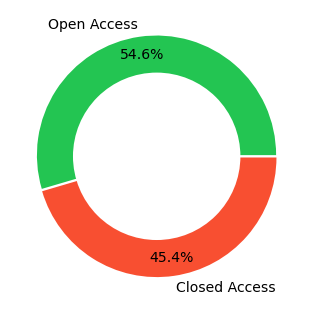

In [5]:
def create_donut_plot(open_works_count, closed_works_count):
    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"] = (8,5.5)

    # set labels and their respective values
    groups = ['Open Access', 'Closed Access']
    counts = [open_works_count, closed_works_count]

    # some visual settings
    colors = ['#23c552', '#f84f31']
    explode = (0.01, 0.01)

    # pie chart
    plt.pie(counts, colors=colors, labels=groups,
            autopct='%1.1f%%', pctdistance=0.85,
            explode=explode, textprops={'fontsize': 14})

    # make it a donut (draw circle in the middle)
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    # display chart
    plt.show()

# create donut chart from open/closed counts
create_donut_plot(open_works_count, closed_works_count)

---
Feel free to use the notebook and determine the percentage of Open Access works for your institution or tweak the filters to fit your analysis.  

Happy exploring! 😎